In [1]:
from glob import glob
import pickle
import os
import numpy as np
from typing import Any, Dict, List, Tuple, Union
#from argoverse.map_representation.map_api import ArgoverseMap
import torch
from torch import nn, optim, utils
from torch.utils.data import IterableDataset, DataLoader, Dataset
from tqdm import tqdm
import sys
import pandas as pd
import dill
import cv2

import io
import math
from pathlib import Path
#from typing import Final, List, Optional, Sequence, Set, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from PIL import Image as img
from PIL.Image import Image

sys.path.append("/data/jedrzej/Argoverse2/av2_prerelease_sample_code")

from lib.data.data_schema import (
    ArgoverseScenario,
    ObjectType,
    Polyline,
    ScenarioStaticMap,
    TrackCategory,
)

from shapely.geometry import Point, LineString, MultiLineString
from shapely import affinity
from lib.data.scenario_serialization import load_argoverse_scenario_parquet, load_static_map_json

In [33]:
!ls /data/jedrzej/argo2city/processed/train

argo2_scenes_0.pkl   argo2_scenes_16.pkl  argo2_scenes_4.pkl
argo2_scenes_10.pkl  argo2_scenes_17.pkl  argo2_scenes_5.pkl
argo2_scenes_11.pkl  argo2_scenes_18.pkl  argo2_scenes_6.pkl
argo2_scenes_12.pkl  argo2_scenes_19.pkl  argo2_scenes_7.pkl
argo2_scenes_13.pkl  argo2_scenes_1.pkl   argo2_scenes_8.pkl
argo2_scenes_14.pkl  argo2_scenes_2.pkl   argo2_scenes_9.pkl
argo2_scenes_15.pkl  argo2_scenes_3.pkl


In [2]:
from pathlib import Path

path_list = glob('/data/jedrzej/Argoverse2/val/*')
argoverse_scenario_dir = Path('/data/jedrzej/Argoverse2/val/')
all_scenario_files = sorted(argoverse_scenario_dir.rglob("*.parquet"))


In [5]:
!ls /home/user/miniconda3/envs/

pecco  trajectron++


In [9]:
! ls /data/jedrzej/Argoverse2/val/c950e7ef-4f5f-4c7e-a452-84c420275957/

log_map_archive_c950e7ef-4f5f-4c7e-a452-84c420275957.json
scenario_c950e7ef-4f5f-4c7e-a452-84c420275957.parquet


In [36]:
p = path_list[0]

In [39]:
p = path_list[0]
scenario_id = p.split("/")[-1]

In [41]:
map_path = os.path.join(p, f"log_map_archive_{scenario_id}.json")
parquet_path = os.path.join(p, f"scenario_{scenario_id}.parquet")
map_path

'/data/jedrzej/Argoverse2/val/c950e7ef-4f5f-4c7e-a452-84c420275957/log_map_archive_c950e7ef-4f5f-4c7e-a452-84c420275957.json'

In [5]:

scenario_path = all_scenario_files[0]
scenario_id = scenario_path.stem.split("_")[-1]
static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = load_argoverse_scenario_parquet(scenario_path)
static_map = load_static_map_json(static_map_path)

In [6]:
static_map.keys()

dict_keys(['drivable_areas', 'lane_segments', 'pedestrian_crossings'])

In [7]:
area = static_map['drivable_areas']['22609599']['area_boundary']
xs = [a['x'] for a in area]
ys = [a['y'] for a in area]

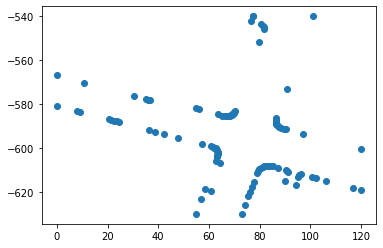

In [8]:
plt.scatter(xs,ys)

In [9]:
centerlane = [b['centerline'] for _,b in static_map['lane_segments'].items()]
xs = [[a['x'] for a in c] for c in centerlane]
ys = [[a['y'] for a in c] for c in centerlane]
xs = np.concatenate(xs)
ys = np.concatenate(ys)

In [10]:
centerlane[0]

[{'x': 90.67, 'y': -594.76, 'z': 0.0},
 {'x': 88.85, 'y': -594.24, 'z': 0.0},
 {'x': 87.03, 'y': -593.73, 'z': 0.0},
 {'x': 85.21, 'y': -593.21, 'z': 0.0},
 {'x': 83.39, 'y': -592.7, 'z': 0.0},
 {'x': 81.57, 'y': -592.18, 'z': 0.0},
 {'x': 79.76, 'y': -591.67, 'z': 0.0},
 {'x': 77.94, 'y': -591.15, 'z': 0.0},
 {'x': 76.12, 'y': -590.63, 'z': 0.0},
 {'x': 74.3, 'y': -590.12, 'z': 0.0},
 {'x': 72.48, 'y': -589.6, 'z': 0.0},
 {'x': 70.66, 'y': -589.09, 'z': 0.0},
 {'x': 68.84, 'y': -588.57, 'z': 0.0},
 {'x': 67.02, 'y': -588.06, 'z': 0.0},
 {'x': 65.2, 'y': -587.54, 'z': 0.0},
 {'x': 63.39, 'y': -586.99, 'z': 0.0}]

In [11]:
xs = np.concatenate(xs)
ys = np.concatenate(ys)

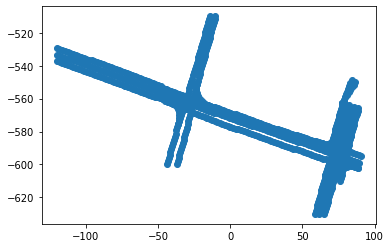

In [26]:
plt.scatter(xs,ys)

In [13]:
from shapely.geometry import Point, LineString, MultiLineString
from shapely import affinity


coords = [((c[0]['x'],c[0]['y']),(c[-1]['x'],c[-1]['y'])) for c in centerlane]

lines = MultiLineString(coords)

In [24]:
min_x, max_x = min(xs), max(xs)
min_y, max_y = min(ys), max(ys)
patch_h = max_y - min_y
patch_w = max_x - min_x
patch_x = min_x + patch_w/2.0
patch_y = min_y + patch_h/2.0

canvas_size = (np.round(3 * patch_h).astype(int), np.round(3 * patch_w).astype(int))

canvas_h = canvas_size[0]
canvas_w = canvas_size[1]
scale_height = canvas_h/patch_h
scale_width = canvas_w/patch_w

trans_x = -patch_x + patch_w / 2.0
trans_y = -patch_y + patch_h / 2.0


map_mask = np.zeros(canvas_size, np.uint8)

for line in lines:
    #new_line = line.intersection(patch)
    new_line = affinity.affine_transform(line,
                                         [1.0, 0.0, 0.0, 1.0, trans_x, trans_y])
    new_line = affinity.scale(new_line, xfact=scale_width, yfact=scale_height, origin=(0, 0))
    
    coords = np.asarray(list(new_line.coords), np.int32)
    coords = coords.reshape((-1, 2))
    msk = cv2.polylines(map_mask, [coords], False, 1, 2)
    

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


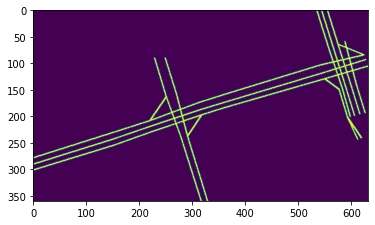

In [25]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(msk*255)
plt.show()

In [19]:
msk.sum()

1769

In [79]:
new_line.coords.xy

(array('d', [34.82223382541415, 22.57084539801585]),
 array('d', [57.90000000000002, 64.79166666666667]))

## Yay! ok here are the actual processing script

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import dill
import argparse
from tqdm import tqdm
from pyquaternion import Quaternion
#from kalman_filter import NonlinearKinematicBicycle
from sklearn.model_selection import train_test_split

#sys.path.append("../../trajectron")

from environment import Environment, Scene, Node, GeometricMap, derivative_of
from pathlib import Path
from collections import defaultdict

#scene_blacklist = [499, 515, 517]

In [4]:
FREQUENCY = 10
dt = 1 / FREQUENCY
data_columns_vehicle = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration', 'heading'], ['x', 'y']])
data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_tuples([('heading', '°'), ('heading', 'd°')]))
data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_product([['velocity', 'acceleration'], ['norm']]))

data_columns_pedestrian = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])

curv_0_2 = 0
curv_0_1 = 0
total = 0


standardization = {
    'PEDESTRIAN': {
        'position': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 2},
            'y': {'mean': 0, 'std': 2}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        }
    },
    'VEHICLE': {
        'position': {
            'x': {'mean': 0, 'std': 80},
            'y': {'mean': 0, 'std': 80}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 15},
            'y': {'mean': 0, 'std': 15},
            'norm': {'mean': 0, 'std': 15}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 4},
            'y': {'mean': 0, 'std': 4},
            'norm': {'mean': 0, 'std': 4}
        },
        'heading': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1},
            '°': {'mean': 0, 'std': np.pi},
            'd°': {'mean': 0, 'std': 1}
        }
    }
}

In [5]:
path_list = glob('/data/jedrzej/argo2city/val/*')
path_list

['/data/jedrzej/argo2city/val/c950e7ef-4f5f-4c7e-a452-84c420275957',
 '/data/jedrzej/argo2city/val/1d0f3e14-d678-4829-b1b6-fd308f5979c1',
 '/data/jedrzej/argo2city/val/d6db9399-788f-404e-b540-2b426b7c3609',
 '/data/jedrzej/argo2city/val/61d3a2e0-54c9-4551-a93a-9a5f6b9a8491',
 '/data/jedrzej/argo2city/val/6640cd41-4d57-40c2-af71-5b901b0dfbe5',
 '/data/jedrzej/argo2city/val/1e55a764-c62a-46a1-ab1e-1ec18ef6bd42',
 '/data/jedrzej/argo2city/val/0563dead-5e96-4d59-852a-4a9efaa76123',
 '/data/jedrzej/argo2city/val/4cf562fa-77db-4597-9a71-0f1353c4060f',
 '/data/jedrzej/argo2city/val/f3e33438-dc12-4128-8da4-d2f8c3fbc428',
 '/data/jedrzej/argo2city/val/b6d50693-4422-4621-b5f0-8f320f879dbe',
 '/data/jedrzej/argo2city/val/1dbd9470-be34-42d7-9001-d39e7f4ea7af',
 '/data/jedrzej/argo2city/val/8e555a52-3843-4b77-9611-bee4019960b4',
 '/data/jedrzej/argo2city/val/fc5f9a35-606b-4eba-8627-392b99895e1b',
 '/data/jedrzej/argo2city/val/23feb652-7030-4feb-a29f-e18de2e2b4c1',
 '/data/jedrzej/argo2city/val/da6a

In [6]:


def process_data(data_path, version, output_path):
   
    for data_class in ['train', 'val']:
        env = Environment(node_type_list=['VEHICLE'], standardization=standardization) #, 'PEDESTRIAN'
        attention_radius = dict()
        attention_radius[('PEDESTRIAN', 'PEDESTRIAN')] = 10.0
        attention_radius[('PEDESTRIAN', 'VEHICLE')] = 20.0
        attention_radius[('VEHICLE', 'PEDESTRIAN')] = 20.0
        attention_radius[('VEHICLE', 'VEHICLE')] = 30.0

        env.attention_radius = attention_radius
        env.robot_type = env.NodeType.VEHICLE
        scenes = defaultdict(list)
        
        input_path = os.path.join(data_path, data_class, '*')
        path_list = glob(input_path)

        for p in tqdm(path_list):

            scene, city = process_scene(p)
            
            if scene is not None:
                '''
                if data_class == 'train':
                    scene.augmented = list()
                    angles = np.arange(0, 360, 15)
                    for angle in angles:
                        scene.augmented.append(augment_scene(scene, angle))
                '''
                scenes[city].append(scene)

        print(f'Processed {len(scenes):.2f} scenes')

        env.scenes = scenes
        
        for c in scenes.keys():
            if data_class == 'val':
                city_scenes = scenes[c]
            if data_class == 'train':
                city_scenes = []
                for citi, sce in scenes.items():
                    if city!=c:
                        city_scenes += sce
            
            env.scenes = city_scenes

            data_dict_path = os.path.join(output_path, 'nuScenes_' + data_class + mini_string + '_full.pkl')
            with open(data_dict_path, 'wb') as f:
                dill.dump(env, f, protocol=dill.HIGHEST_PROTOCOL)
            print('Saved Environment!')


        print(f"Total Nodes: {total}")
        total = 0

In [27]:

def process_scene(p):
    scenario_id = p.split("/")[-1]

    map_path = os.path.join(p, f"log_map_archive_{scenario_id}.json")
    parquet_path = os.path.join(p, f"scenario_{scenario_id}.parquet")

    scenario = load_argoverse_scenario_parquet(parquet_path)

    scene_id = scenario.scenario_id
    city = scenario.city
    
    data = pd.DataFrame(columns=['scene_id',
                                'frame_id',
                                 'type',
                                 'node_id',
                                 'robot',
                                 'x', 'y',
                                 'heading'])

    data_columns_vehicle = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])
    data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_tuples([('heading', '°')]))
    
    for track in scenario.tracks:
        track_id = track.track_id
        category = track.object_type.value
        isagent = track.category.value == 2 # if ==2 then is agent

        #only look at pedestrian and vehicles 
        if category=='pedestrian':
            our_category = 'PEDESTRIAN'
        elif category == 'vehicle' or category == 'motorcyclist':
            our_category = 'VEHICLE' #env.NodeType.VEHICLE
        else:
            continue

        trackstates = track.object_states
        xy = [s.position for s in trackstates]
        heading = [s.heading for s in trackstates]
        velocity =  [s.velocity for s in trackstates]

        for state in trackstates:
            data_point = pd.Series({'scene_id': scene_id,
                                    'frame_id': state.timestep,
                                    'type': our_category,
                                    'node_id': 'ego' if isagent else track_id,
                                    'robot': isagent,
                                    'x': state.position[0],
                                    'y': state.position[1],
                                    'vx': state.velocity[0],
                                    'vy': state.velocity[1],
                                    'heading': state.heading})
            data = data.append(data_point, ignore_index=True)

    data.sort_values('frame_id', inplace=True)

    x_min = np.round(data['x'].min())
    x_max = np.round(data['x'].max())
    y_min = np.round(data['y'].min())
    y_max = np.round(data['y'].max())

    data['x'] = data['x'] - x_min
    data['y'] = data['y'] - y_min

    max_timesteps = data['frame_id'].max()
    scene = Scene(timesteps=max_timesteps + 1, dt=0.1, name=str(scene_id))


    # -- process map --

    static_map = load_static_map_json(map_path)
    centerlane = [b['centerline'] for _,b in static_map['lane_segments'].items()]
    xs = [[a['x'] for a in c] for c in centerlane]
    ys = [[a['y'] for a in c] for c in centerlane]
    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    coords = [((c[0]['x'],c[0]['y']),(c[-1]['x'],c[-1]['y'])) for c in centerlane]

    lines = MultiLineString(coords)

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    patch_h = max_y - min_y
    patch_w = max_x - min_x
    patch_x = min_x + patch_w/2.0
    patch_y = min_y + patch_h/2.0

    canvas_size = (np.round(3 * patch_h).astype(int), np.round(3 * patch_w).astype(int))

    canvas_h = canvas_size[0]
    canvas_w = canvas_size[1]
    scale_height = canvas_h/patch_h
    scale_width = canvas_w/patch_w

    trans_x = -patch_x + patch_w / 2.0
    trans_y = -patch_y + patch_h / 2.0

    map_mask = np.zeros(canvas_size, np.uint8)

    for line in lines:
        #new_line = line.intersection(patch)
        new_line = affinity.affine_transform(line,
                                             [1.0, 0.0, 0.0, 1.0, trans_x, trans_y])
        new_line = affinity.scale(new_line, xfact=scale_width, yfact=scale_height, origin=(0, 0))

        coords = np.asarray(list(new_line.coords), np.int32)
        coords = coords.reshape((-1, 2))
        msk = cv2.polylines(map_mask, [coords], False, 1, 2)


    homography = np.array([[3., 0., 0.], [0., 3., 0.], [0., 0., 3.]])
    geo_map = GeometricMap(data=msk, homography=homography, description='map')
    type_map = {'PEDESTRIAN':geo_map, 'VEHICLE':geo_map, 'VISUALIZATION':geo_map}
    scene.map = type_map

    # -- end of map procecing -- 

    for node_id in pd.unique(data['node_id']):

        node_df = data[data['node_id'] == node_id]
        vx = node_df['vx'].values
        vy = node_df['vy'].values

        ax = derivative_of(vx, scene.dt)
        ay = derivative_of(vy, scene.dt)


        data_dict = {('position', 'x'): node_df['x'].values,
                     ('position', 'y'): node_df['y'].values,
                     ('velocity', 'x'): vx,
                     ('velocity', 'y'): vy,
                     ('acceleration', 'x'): ax,
                     ('acceleration', 'y'): ay,
                     ('heading', '°'): node_df['heading'].values}

        node_data = pd.DataFrame(data_dict, columns=data_columns_vehicle)
        node = Node(node_type=node_df.iloc[0]['type'], node_id=node_id, data=node_data)
        scene.nodes.append(node)

    return scene, city

In [28]:
p = path_list[0]
process_scene(p)

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(Scene: Duration: 11.0s, Nodes: 3, Map: Yes., 'dearborn')

In [26]:
len(node_data)

110

In [19]:
scenario_id = p.split("/")[-1]

map_path = os.path.join(p, f"log_map_archive_{scenario_id}.json")
parquet_path = os.path.join(p, f"scenario_{scenario_id}.parquet")

scenario = load_argoverse_scenario_parquet(parquet_path)

scene_id = scenario.scenario_id
city = scenario.city

data = pd.DataFrame(columns=['scene_id',
                            'frame_id',
                             'type',
                             'node_id',
                             'robot',
                             'x', 'y',
                             'heading'])

data_columns_vehicle = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])
data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_tuples([('heading', '°')]))

for track in scenario.tracks:
    track_id = track.track_id
    category = track.object_type.value
    isagent = track.category.value == 2 # if ==2 then is agent

    #only look at pedestrian and vehicles 
    if category=='pedestrian':
        our_category = 'PEDESTRIAN'
    elif category == 'vehicle' or category == 'motorcyclist':
        our_category = 'VEHICLE' #env.NodeType.VEHICLE
    else:
        continue

    trackstates = track.object_states
    xy = [s.position for s in trackstates]
    heading = [s.heading for s in trackstates]
    velocity =  [s.velocity for s in trackstates]

    for state in trackstates:
        data_point = pd.Series({'scene_id': scene_id,
                                'frame_id': state.timestep,
                                'type': our_category,
                                'node_id': 'ego' if isagent else track_id,
                                'robot': isagent,
                                'x': state.position[0],
                                'y': state.position[1],
                                'vx': state.velocity[0],
                                'vy': state.velocity[1],
                                'heading': state.heading})
        data = data.append(data_point, ignore_index=True)

data.sort_values('frame_id', inplace=True)

x_min = np.round(data['x'].min())
x_max = np.round(data['x'].max())
y_min = np.round(data['y'].min())
y_max = np.round(data['y'].max())

data['x'] = data['x'] - x_min
data['y'] = data['y'] - y_min

max_timesteps = data['frame_id'].max()
scene = Scene(timesteps=max_timesteps + 1, dt=0.1, name=str(scene_id))


# -- end of map procecing -- 

for node_id in pd.unique(data['node_id']):

    node_df = data[data['node_id'] == node_id]
    vx = node_df['vx'].values
    vy = node_df['vy'].values

    ax = derivative_of(vx, scene.dt)
    ay = derivative_of(vy, scene.dt)


    data_dict = {('position', 'x'): node_df['x'].values,
                 ('position', 'y'): node_df['y'].values,
                 ('velocity', 'x'): vx,
                 ('velocity', 'y'): vy,
                 ('acceleration', 'x'): ax,
                 ('acceleration', 'y'): ay,
                 ('heading', '°'): node_df['heading'].values}

    node_data = pd.DataFrame(data_dict, columns=data_columns_vehicle)
    node = Node(node_type=node_df.iloc[0]['type'], node_id=node_id, data=node_data)
    scene.nodes.append(node)

In [107]:
! mkdir /data/jedrzej/argo2city/processed/val

mkdir: cannot create directory ‘/data/jedrzej/argo2city/processed/val’: Permission denied


In [28]:
print(sys.path)

['/home/user/miniconda3/envs/trajectron++/lib/python36.zip', '/home/user/miniconda3/envs/trajectron++/lib/python3.6', '/home/user/miniconda3/envs/trajectron++/lib/python3.6/lib-dynload', '', '/home/user/.local/lib/python3.6/site-packages', '/home/user/miniconda3/envs/trajectron++/lib/python3.6/site-packages', '/home/user/.local/lib/python3.6/site-packages/IPython/extensions', '/home/user/.ipython', '/data/jedrzej/Argoverse2/av2_prerelease_sample_code', '/data/jedrzej/Argoverse2/av2_prerelease_sample_code']


In [27]:
data_class = 'val'
data_path = '/data/jedrzej/argo2city/'
output_path = '/data/jedrzej/argo2city/processed/val'

env = Environment(node_type_list=['PEDESTRIAN', 'VEHICLE'], standardization=standardization) #, 'PEDESTRIAN'
attention_radius = dict()
attention_radius[('PEDESTRIAN', 'PEDESTRIAN')] = 10.0
attention_radius[('PEDESTRIAN', 'VEHICLE')] = 20.0
attention_radius[('VEHICLE', 'PEDESTRIAN')] = 20.0
attention_radius[('VEHICLE', 'VEHICLE')] = 30.0

env.attention_radius = attention_radius
env.robot_type = env.NodeType.VEHICLE
scenes = defaultdict(list)

input_path = os.path.join(data_path, data_class, '*')
path_list = glob(input_path)

count = 0
for p in tqdm(path_list):

    scene, city = process_scene(p)

    if scene is not None:
        '''
        if data_class == 'train':
            scene.augmented = list()
            angles = np.arange(0, 360, 15)
            for angle in angles:
                scene.augmented.append(augment_scene(scene, angle))
        '''
        scenes[city].append(scene)
    count += 1
    if count > 20:
        break

print(f'Processed {len(scenes):.2f} scenes')

#env.scenes = scenes

for c in scenes.keys():
    if data_class == 'val':
        city_scenes = scenes[c]
    if data_class == 'train':
        city_scenes = []
        for citi, sce in scenes.items():
            if city!=c:
                city_scenes += sce

    env.scenes = city_scenes

    data_dict_path = os.path.join(output_path, 'argo2city_' + c + '_' + data_class + '_full.pkl')
    with open(data_dict_path, 'wb') as f:
        dill.dump(env, f, protocol=dill.HIGHEST_PROTOCOL)
    print('Saved Environment! ' + c)


print(f"Total Nodes: {total}")

  0%|          | 20/25000 [00:13<4:47:11,  1.45it/s]

Processed 5.00 scenes


PermissionError: [Errno 13] Permission denied: '/data/jedrzej/argo2city/processed/val/argo2city_dearborn_val_full.pkl'

In [110]:
scenario

ArgoverseScenario(scenario_id='00010486-9a07-48ae-b493-cf4545855937', timestamps=array([3.15977348e+17, 3.15977348e+17, 3.15977348e+17, 3.15977349e+17,
       3.15977349e+17, 3.15977349e+17, 3.15977349e+17, 3.15977349e+17,
       3.15977349e+17, 3.15977349e+17, 3.15977349e+17, 3.15977349e+17,
       3.15977349e+17, 3.15977350e+17, 3.15977350e+17, 3.15977350e+17,
       3.15977350e+17, 3.15977350e+17, 3.15977350e+17, 3.15977350e+17,
       3.15977350e+17, 3.15977350e+17, 3.15977350e+17, 3.15977351e+17,
       3.15977351e+17, 3.15977351e+17, 3.15977351e+17, 3.15977351e+17,
       3.15977351e+17, 3.15977351e+17, 3.15977351e+17, 3.15977351e+17,
       3.15977351e+17, 3.15977352e+17, 3.15977352e+17, 3.15977352e+17,
       3.15977352e+17, 3.15977352e+17, 3.15977352e+17, 3.15977352e+17,
       3.15977352e+17, 3.15977352e+17, 3.15977352e+17, 3.15977353e+17,
       3.15977353e+17, 3.15977353e+17, 3.15977353e+17, 3.15977353e+17,
       3.15977353e+17, 3.15977353e+17, 3.15977353e+17, 3.15977353e+

In [86]:
msk.shape

(360, 632)

In [46]:
scenario = load_argoverse_scenario_parquet(scenario_path)

ArgoverseScenario(scenario_id='00010486-9a07-48ae-b493-cf4545855937', timestamps=array([3.15977348e+17, 3.15977348e+17, 3.15977348e+17, 3.15977349e+17,
       3.15977349e+17, 3.15977349e+17, 3.15977349e+17, 3.15977349e+17,
       3.15977349e+17, 3.15977349e+17, 3.15977349e+17, 3.15977349e+17,
       3.15977349e+17, 3.15977350e+17, 3.15977350e+17, 3.15977350e+17,
       3.15977350e+17, 3.15977350e+17, 3.15977350e+17, 3.15977350e+17,
       3.15977350e+17, 3.15977350e+17, 3.15977350e+17, 3.15977351e+17,
       3.15977351e+17, 3.15977351e+17, 3.15977351e+17, 3.15977351e+17,
       3.15977351e+17, 3.15977351e+17, 3.15977351e+17, 3.15977351e+17,
       3.15977351e+17, 3.15977352e+17, 3.15977352e+17, 3.15977352e+17,
       3.15977352e+17, 3.15977352e+17, 3.15977352e+17, 3.15977352e+17,
       3.15977352e+17, 3.15977352e+17, 3.15977352e+17, 3.15977353e+17,
       3.15977353e+17, 3.15977353e+17, 3.15977353e+17, 3.15977353e+17,
       3.15977353e+17, 3.15977353e+17, 3.15977353e+17, 3.15977353e+

In [71]:
types = [c.object_type for c in scenario.tracks]
categoreis = [c.category for c in scenario.tracks]

In [79]:
#categories: 2 is agent
#[0].value#.__dir__()
categoreis

[<TrackCategory.UNSCORED_TRACK: 1>,
 <TrackCategory.FOCAL_TRACK: 3>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.UNSCORED_TRACK: 1>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.SCORED_TRACK: 2>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0>,
 <TrackCategory.TRACK_FRAGMENT: 0

In [84]:
#types[0].value
types

[<ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.MOTORCYCLIST: 'motorcyclist'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.PEDESTRIAN: 'pedestrian'>,
 <ObjectType.PEDESTRIAN: 'pedestrian'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.RIDERLESS_BICYCLE: 'riderless_bicycle'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.PEDESTRIAN: 'pedestrian'>,
 <ObjectType.STATIC: 'static'>,
 <ObjectType.BACKGROUND: 'background'>,
 <ObjectType.CONSTRUCTION: 'construction'>,
 <ObjectType.VEHICLE: 'vehicle'>,
 <ObjectType.CONSTRU

In [70]:
scenario.tracks[0]

Track(track_id='77543', object_states=[ObjectState(observed=True, timestep=0, position=(-11.823673649007935, -567.4023974854001), heading=2.8502121782024448, velocity=(-10.135779773162483, 3.0359271296884756)), ObjectState(observed=True, timestep=1, position=(-12.39320578754739, -567.2253156611156), heading=2.8500757486227837, velocity=(-10.164790448705373, 3.0329899998597862)), ObjectState(observed=True, timestep=2, position=(-13.080372362384209, -567.0096938093519), heading=2.849729679583497, velocity=(-10.185671800671363, 3.031218812995912)), ObjectState(observed=True, timestep=3, position=(-13.880497176060121, -566.7544103059896), heading=2.8490452955231054, velocity=(-10.144088795057396, 3.0140308580389377)), ObjectState(observed=True, timestep=4, position=(-14.773626809536655, -566.4653864371573), heading=2.8479616883793915, velocity=(-10.107290461858751, 2.997264820097428)), ObjectState(observed=True, timestep=5, position=(-15.74815042844231, -566.1455193078166), heading=2.84654

In [64]:
scenario.tracks[0].object_states

[ObjectState(observed=True, timestep=0, position=(-11.823673649007935, -567.4023974854001), heading=2.8502121782024448, velocity=(-10.135779773162483, 3.0359271296884756)),
 ObjectState(observed=True, timestep=1, position=(-12.39320578754739, -567.2253156611156), heading=2.8500757486227837, velocity=(-10.164790448705373, 3.0329899998597862)),
 ObjectState(observed=True, timestep=2, position=(-13.080372362384209, -567.0096938093519), heading=2.849729679583497, velocity=(-10.185671800671363, 3.031218812995912)),
 ObjectState(observed=True, timestep=3, position=(-13.880497176060121, -566.7544103059896), heading=2.8490452955231054, velocity=(-10.144088795057396, 3.0140308580389377)),
 ObjectState(observed=True, timestep=4, position=(-14.773626809536655, -566.4653864371573), heading=2.8479616883793915, velocity=(-10.107290461858751, 2.997264820097428)),
 ObjectState(observed=True, timestep=5, position=(-15.74815042844231, -566.1455193078166), heading=2.846542156750936, velocity=(-10.0823344

# Consolidation

In [31]:
path_list = glob('/data/jedrzej/argo2city/processed/train/*')
path_list

['/data/jedrzej/argo2city/processed/train/argo2_scenes_1.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_12.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_11.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_5.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_13.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_8.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_3.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_4.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_9.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_0.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_2.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_7.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_6.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_15.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_scenes_10.pkl',
 '/data/jedrzej/argo2city/processed/train/argo2_sc

In [33]:
scenes = {}

for filepath in path_list:
    with open(filepath, 'rb') as f:
        this_scene = pickle.load(f)
    break

In [35]:
cities = list(this_scene.keys())
cities

['austin', 'miami', 'dearborn', 'pittsburgh', 'washington-dc', 'palo-alto']

In [37]:
for c in cities:
    
    env = Environment(node_type_list=['PEDESTRIAN', 'VEHICLE'], standardization=standardization) #, 'PEDESTRIAN'
    attention_radius = dict()
    attention_radius[('PEDESTRIAN', 'PEDESTRIAN')] = 10.0
    attention_radius[('PEDESTRIAN', 'VEHICLE')] = 20.0
    attention_radius[('VEHICLE', 'PEDESTRIAN')] = 20.0
    attention_radius[('VEHICLE', 'VEHICLE')] = 30.0

    env.attention_radius = attention_radius
    env.robot_type = env.NodeType.VEHICLE
    
    scenes = []

    for filepath in tqdm(path_list):
        with open(filepath, 'rb') as f:
            this_scene = pickle.load(f)
            for citi, sce in this_scene.items():
                    if city!=c:
                        scenes += sce
    
    env.scenes = scenes

    data_dict_path = os.path.join('/data/jedrzej/argo2city/processed/train/',  c + '_trainingfull.pkl')
    with open(data_dict_path, 'wb') as f:
        dill.dump(env, f, protocol=dill.HIGHEST_PROTOCOL)
    print('Saved Environment! ' + c)
    del scenes
        

100%|██████████| 16/16 [03:57<00:00, 14.82s/it]


PermissionError: [Errno 13] Permission denied: '/data/jedrzej/argo2city/processed/train/austin_trainingfull.pkl'

In [38]:
path_list = glob('/data/jedrzej/argo2city/processed/val/*')
path_list

['/data/jedrzej/argo2city/processed/val/argo2city_pittsburgh_full.pkl',
 '/data/jedrzej/argo2city/processed/val/argo2city_washington-dc_full.pkl',
 '/data/jedrzej/argo2city/processed/val/argo2city_dearborn_full.pkl',
 '/data/jedrzej/argo2city/processed/val/argo2city_austin_full.pkl',
 '/data/jedrzej/argo2city/processed/val/argo2city_miami_full.pkl',
 '/data/jedrzej/argo2city/processed/val/argo2city_palo-alto_full.pkl']

In [39]:
scenes = {}
for filepath in path_list:
    city = filepath.split('_')[1]
    with open(filepath, 'rb') as f:
        envs = pickle.load(f)
        scenes[city] = envs.scenes


In [45]:
path_list[0][-9:]

'_full.pkl'

In [42]:
filepath.split('_')[1]
scenes[city] = envs.scenes

'pittsburgh'

In [40]:
scenes = envs.scenes
len(scenes)

5330

In [29]:
path_list = glob('/data/jedrzej/argo2city/train/*')


In [30]:
len(path_list)

200000